In [1]:
#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%%capture
!pip install transformers=='4.29.2' wordcloud sklearn

# <font color=#003091> Clasificación de textos con Transformers provenientes de HuggingFace en Keras - IMDB </font>

Este notebook introduce los conceptos que se encuentran detrás de la librería transformers BERT y como se puede utilizar para la clasificación de textos con Keras.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

from tensorflow import keras

from sklearn.model_selection import train_test_split

from tqdm import tqdm
import numpy as np

%matplotlib inline
import matplotlib as mpl
mpl.rc("figure", figsize=(16, 9))

In [5]:
from transformers import *  # this is HuggingFace library
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel, BertConfig

/usr/local/lib/python3.10/dist-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_flax_utils.py:24: FutureWarning: Importing `FlaxGenerationMixin` from `src/transformers/generation_flax_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import FlaxGenerationMixin` instead.
  warnings.warn(
Xformers is not installed correctly. If you want to use memorry_efficient_attenti

In [6]:
# Esta opción permite que Pandas muestre todo el contenido de una columa
#  Por defecto, al hacer print, Pandas trunca la longitud de los textos que muestra
pd.set_option('display.max_colwidth', -1)

<ipython-input-6-a29c9bd96430>:3: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


## Objetivo IMDB: Predicción de sentimiento
Durante este Notebook, vamos a procesar varios reviews de películas. Nuestro objetivo será identificar si la película le ha gustado al escritor.


In [7]:
path = "/content/drive/MyDrive/Colab_Notebooks/University/Deep Learning/6. Transformers - Text/"

imdb_data=pd.read_csv(path+'input/IMDB Dataset.csv')
print(imdb_data.shape)
imdb_data.head()

(50000, 2)


,review,sentiment
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side.",positive
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.",positive
2,"I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I'd laughed at one of Woody's comedies in years (dare I say a decade?). While I've never been impressed with Scarlet Johanson, in this she managed to tone down her ""sexy"" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than ""Devil Wears Prada"" and more interesting than ""Superman"" a great comedy to go see with friends.",positive
3,"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zom

## 1. Breve análisis descriptivo
Previo a utilizar cualquier cualquier modelo, necesitamos entender el conjunto de datos a predecir.

- Se puede comprobar que 418 textos son repetidos

In [8]:
imdb_data.describe().T

,count,unique,top,freq
review,50000,49582,"Loved today's show!!! It was a variety and not solely cooking (which would have been great too). Very stimulating and captivating, always keeping the viewer peeking around the corner to see what was coming up next. She is as down to earth and as personable as you get, like one of us which made the show all the more enjoyable. Special guests, who are friends as well made for a nice surprise too. Loved the 'first' theme and that the audience was invited to play along too. I must admit I was shocked to see her come in under her time limits on a few things, but she did it and by golly I'll be writing those recipes down. Saving time in the kitchen means more time with family. Those who haven't tuned in yet, find out what channel and the time, I assure you that you won't be disappointed.",5
sentiment,50000,2,positive,25000


- El conjunto de datos está equilibrado - 50% de reviews positivos y negativos

In [9]:
imdb_data['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

- Se puede comprobar como una de las frases duplicadas (la más común) es relativamente largas. Sería raro que  varias personas se les hayan ocurrido las misma frases. En una situación normal habría que eliminar estos duplicados.

TODO: Como tarea os dejo revisar si estas frases duplicadas tiene el mismo sentimento asignado.

In [10]:
# Se muestran las frases más repetidas de más a menos
#  (Cada frase se muestra en una línea - al final aparece cuanto se repite)
imdb_data["review"].astype(str).value_counts().head()

Loved today's show!!! It was a variety and not solely cooking (which would have been great too). Very stimulating and captivating, always keeping the viewer peeking around the corner to see what was coming up next. She is as down to earth and as personable as you get, like one of us which made the show all the more enjoyable. Special guests, who are friends as well made for a nice surprise too. Loved the 'first' theme and that the audience was invited to play along too. I must admit I was shocked to see her come in under her time limits on a few things, but she did it and by golly I'll be writing those recipes down. Saving time in the kitchen means more time with family. Those who haven't tuned in yet, find out what channel and the time, I assure you that you won't be disappointed.                                                                                                                                                                                                                

### Revisión de textos - WordCloud
Una forma de entender el contenido de las frases es la nube de palabras. Mediante este tipo de herramientas podemos visualizar facilmente las palabras o grupos de palabras más utilizadas.

En este caso, vamos a hacer uso del WordCloud para diferenciar entre las frases positivas y las negativas.

<function matplotlib.pyplot.show(close=None, block=None)>

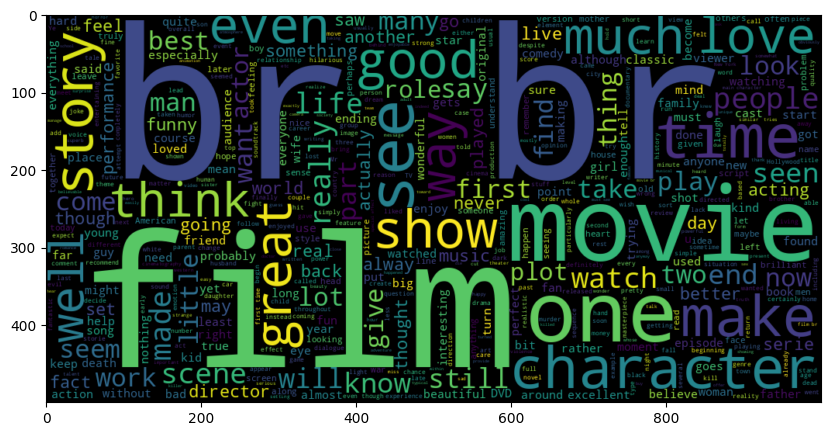

In [11]:
#word cloud for positive review words
positive_words = ' '.join(imdb_data.loc[imdb_data['sentiment']=='positive','review'])

plt.figure(figsize=(10,10))
wc_pos=WordCloud(width=1000,height=500,max_words=500,min_font_size=5).generate(positive_words)
plt.imshow(wc_pos,interpolation='bilinear')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

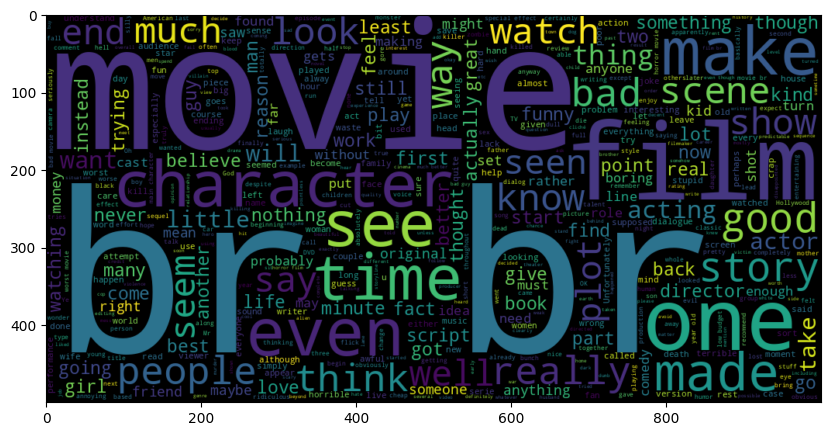

In [12]:
#word cloud for positive review words
negative_words = ' '.join(imdb_data.loc[imdb_data['sentiment']=='negative','review'])

plt.figure(figsize=(10,10))
wc_pos=WordCloud(width=1000,height=500,max_words=500,min_font_size=5).generate(negative_words)
plt.imshow(wc_pos,interpolation='bilinear')
plt.show

# 2. Preprocesamiento

El procesamiento del texto está dividido en 2 Etapas

1. **Limpieza del texto**: el texto actual no completamente legible, hay que transformarlo!
  - Por ejemplo, hay caracteres cómo <br> que significan salto de línea en una página web -> No deberían estar
2. **Conversión del texto a Embeddings**: Se transforma cada palabra a un vector que describe su significado.

### Limpieza de texto

En ejemplos cómo los siguientes, se puede comprobar que el texto

- Eliminar caracteres propios de la página web para denotar negrita, salto de linea, ... (procesamiento HTML)
- Eliminar corchetes y todo lo que contengan dentro (ej: "hola[ej]" --> "hola")

In [13]:
from bs4 import BeautifulSoup
import re

#Eliminar códigos HTML
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Eliminar todo entre corchetes
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

#Eliminación del texto ruidoso - HTML y Corchetes
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

#Aplicar función en la columna review
imdb_data['review_limpio']=imdb_data['review'].apply(denoise_text)

<ipython-input-13-dca6066304a7>:6: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [14]:
imdb_data[['review','review_limpio']].head(1)

,review,review_limpio
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side.","One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side."


### Conversión de texto a Embeddings

Para el procesamiento de textos se utilizará Transfer Learning.

En concreto, se hará uso del modelo BERT (Bidirectional Enconcer Representation from Transformers).

Esta red neuronal nos permite disponer de una representación de las palabras, su significado y semántica, que después podemos utilizar para aplicar al caso de uso que deseemos. Asimismo, cabe destacar que se puede hacer fine-tuning del modelo para modificar la representación de las palabras y que se asemejen más al conjunto de datos con el que vamos a trabajar.

Respecto al **funcionamiento**

- **Entrada**: El modelo recibe el texto en formato de Tokens. Para construir estos tokens se utilizará la función de Bert.
- **Embeddings**: Es la representación de las palabras y subpalabras dentro de la frase. A su vez, esta representación se divide en:
  - **Embedding del token**: Representación de las palabras y sub-palabras.
  - **Embedding posicional**: Representación de la posición de las mismas
    - **Posición del token en frase (Position Embeddings)**: Indica la posición de la palabra en la frase.
    - **Posición de la frase en el texto (Segment Embeddings)**: Indica si la frase es la primera o segunda del texto.

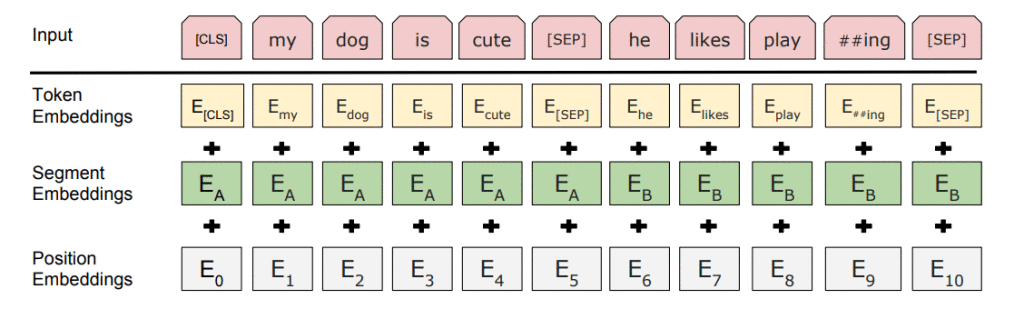

In [15]:
# Este código va a descargar el Tokenizador de BERT
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
# Esto va a descargar el modelo de BERT
# output_hidden_states=False, debido a que el sólo queremos los embeddings, no las predicciones que hacia el modelo
config = BertConfig.from_pretrained("bert-base-uncased",output_hidden_states=False) # dropout=0.2, attention_dropout=0.2
bert_model = TFBertModel.from_pretrained('bert-base-uncased', config=config)

loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/a265f773a47193eed794233aa2a0f0bb6d3eaa63/vocab.txt
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/a265f773a47193eed794233aa2a0f0bb6d3eaa63/tokenizer_config.json


loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/a265f773a47193eed794233aa2a0f0bb6d3eaa63/config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.29.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/a265f773a47193eed794233aa2a0f0bb6d3eaa63/config.js

loading weights file tf_model.h5 from cache at /root/.cache/huggingface/hub/models--bert-base-uncased/snapshots/a265f773a47193eed794233aa2a0f0bb6d3eaa63/tf_model.h5
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training

### Tokenización

A continuación se muestra un ejemplo del funcionamiento de BERT Uncased Tokenizer:

- El modelo BERT, dispone de un vocabulario de 30.522 palabras.
- El proceso de tokenización consiste en dividir el texto de entrada en una lista de tokens disponibles en el vocabulario.
- Para tratar las palabras que no están disponibles en el vocabulario, BERT utiliza una técnica denominada tokenización WordPiece basada en BPE.
  - Una palabra fuera de vocabulario se divide progresivamente en subpalabras y la palabra se representa mediante un grupo de subpalabras. Como las subpalabras forman parte del vocabulario, hemos aprendido a representar un contexto para estas subpalabras y el contexto de la palabra es simplemente la combinación del contexto de las subpalabras.

Asimismo, recordar que los tokens son palabras o subpalabras. Aquí, por ejemplo, "Kaggle" no estaba en el vocabulario del modelo, así que se ha dividido en "ka" y "##ggle". Para indicar que no son palabras separadas, sino partes de una misma palabra, se ha añadido un prefijo de doble hash para "ggle".

fuente: https://swatimeena989.medium.com/bert-text-classification-using-keras-903671e0207d#b60a

In [16]:
sent= 'This is a example Text that we are using for Understanding Purpose, another word that we gonna use is Kaggle'
tokens=bert_tokenizer.tokenize(sent)
print(tokens)

['this', 'is', 'a', 'example', 'text', 'that', 'we', 'are', 'using', 'for', 'understanding', 'purpose', ',', 'another', 'word', 'that', 'we', 'gonna', 'use', 'is', 'ka', '##ggle']


Se puede comprobar cómo divide las palabras en Castellano en muchas mini-palabras, esto es debido a que este BERT sólo está entrenado con palabras en INGLÉS

Los modelos más avanzados son multi-lenguaje debido a que se ha demostrado que ayudan a mejorar

In [17]:
sent_catellano = 'Este es un ejemplo que se está utilizando para entender, y la palabra desconocida es Kaggle'
tokens_catellano = bert_tokenizer.tokenize(sent_catellano)
print(tokens_catellano)

['este', 'es', 'un', 'e', '##je', '##mp', '##lo', 'que', 'se', 'est', '##a', 'ut', '##ili', '##zan', '##do', 'para', 'en', '##ten', '##der', ',', 'y', 'la', 'pal', '##ab', '##ra', 'des', '##con', '##oc', '##ida', 'es', 'ka', '##ggle']


### Encodings
Dada un texto y una longitud de texto máxima, devuelve una lista, de longitud texto máxima, con los id de las palabras y subpalabras obtenidas del texto original.

Además, la función devuelve una máscara de atención. Este artefacto es una lista de la longitud de la lista de palabras que especifica un 1 si la palabra es real (ej: this, example, ...) o un 0 si se ha incluido de relleno debido a que el texto dado no es tan largo.

In [18]:
ids_encode = bert_tokenizer.encode_plus(sent,add_special_tokens = True,max_length =30,pad_to_max_length = True,
return_attention_mask = True)
print("\n\nencode:",ids_encode)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.




encode: {'input_ids': [101, 2023, 2003, 1037, 2742, 3793, 2008, 2057, 2024, 2478, 2005, 4824, 3800, 1010, 2178, 2773, 2008, 2057, 6069, 2224, 2003, 10556, 24679, 102, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]}


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Este proceso se puede revertir con la siguiente función:

In [19]:
# Dado un ID, devuelve la palabra que lo formó
bert_tokenizer.convert_ids_to_tokens(2023)

'this'

#### Encoding de los reviews

In [21]:
sentences = imdb_data['review_limpio']
target_sentences = imdb_data['sentiment']


In [22]:
distribucion_tokens = 500 #imdb_data['review_limpio'].apply(lambda x: len(bert_tokenizer.tokenize(x))).max()

In [23]:
input_ids=[]
attention_masks=[]

for sent in tqdm(sentences):
    bert_inp=bert_tokenizer.encode_plus(sent,add_special_tokens = True,max_length = distribucion_tokens, pad_to_max_length = True,return_attention_mask = True)
    input_ids.append(bert_inp['input_ids'])
    attention_masks.append(bert_inp['attention_mask'])

input_ids=np.asarray(input_ids)
attention_masks=np.array(attention_masks)
target = np.array(pd.get_dummies(target_sentences))

100%|██████████| 50000/50000 [04:25<00:00, 188.61it/s]


In [24]:
input_ids.shape, attention_masks.shape, target.shape

((50000, 500), (50000, 500), (50000, 2))

### División entre Train y Test

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test,train_mask,test_mask=train_test_split(input_ids,target,attention_masks,test_size=0.2)

## 3. Modelo - Clasificador BERT

In [26]:
bert_model.summary()

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
Total params: 109,482,240
Trainable params: 109,482,240
Non-trainable params: 0
_________________________________________________________________


Sólo estamos interesados en token \<cls\>, también denominado token de clasificación

In [27]:
def create_model(model_):
    input_ids = tf.keras.Input(shape=(distribucion_tokens,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(distribucion_tokens,),dtype='int32')

    output = model_(input_ids,attention_masks)
    output = output[0]      # esto está en linea con la configuración previa de config.output_hidden_states debido a que sólo deseamos los embeddings

    output = output[:,0,:]  #  Sólo estamos interesados en token <cls>, también denominado token de clasificación
                            #    Este token contiene la representación de toda la frase
                            #  seleccionando este token, reducimos la dimensionalidad de los datos de 3D a 2D
                            #  Sin embargo, en esta conversión estamos perdiendo información importante.

    output = tf.keras.layers.Dense(128,activation='relu')(output)
    output = tf.keras.layers.Dropout(0.2)(output)
    output = tf.keras.layers.Dense(2,activation='softmax')(output)
    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)

    for layer in model.layers[:3]:
        layer.trainable = False
    return model

model = create_model(bert_model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 500,                                           

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
history=model.fit([X_train,train_mask],y_train,batch_size=32,epochs=4,validation_data=([X_test,test_mask],y_test))

Epoch 1/4
1250/1250 [==============================] - 2196s 2s/step - loss: 0.3839 - accuracy: 0.8263 - val_loss: 0.3609 - val_accuracy: 0.8439
Epoch 2/4
1250/1250 [==============================] - 2189s 2s/step - loss: 0.3515 - accuracy: 0.8462 - val_loss: 0.3255 - val_accuracy: 0.8618
Epoch 3/4
 855/1250 [===================>..........] - ETA: 9:13 - loss: 0.3468 - accuracy: 0.8487